In [9]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from joblib import parallel_backend
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

In [10]:
# Load dataset
df = pd.read_csv('text.csv')
X = df['text']
y = df['label']


In [11]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use a subset of the training data for faster tuning
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.8, stratify=y_train, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train_subset)
X_test_tfidf = vectorizer.transform(X_test)


Training Time: 25.6830 seconds
Prediction Time: 0.0146 seconds
Accuracy: 0.8711
Precision: 0.8711
Recall: 0.8250
F1-Score: 0.8395
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     24201
           1       0.85      0.92      0.89     28164
           2       0.82      0.78      0.80      6929
           3       0.89      0.83      0.86     11441
           4       0.85      0.81      0.83      9594
           5       0.81      0.71      0.76      3033

    accuracy                           0.87     83362
   macro avg       0.86      0.82      0.84     83362
weighted avg       0.87      0.87      0.87     83362



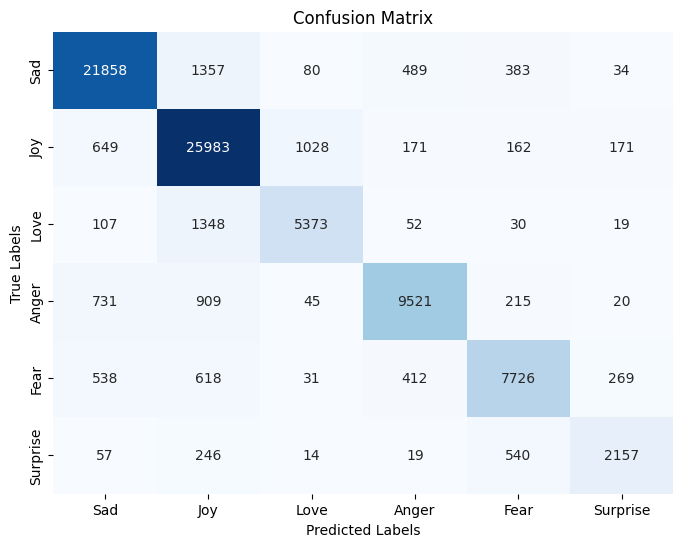

In [12]:
# Initializing SVM model
svm_model = LinearSVC(random_state=42, max_iter=10000)

# Using GridSearchCV for hyperparameter tuning with parallel processing
param_grid = {'C': [0.1, 1, 10]} 
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)  

# Measure training time
start_train_time = time.time()

# Using joblib's parallel_backend to speed up training
with parallel_backend('threading', n_jobs=multiprocessing.cpu_count()):  
    grid_search.fit(X_train_tfidf, y_train_subset)

end_train_time = time.time()
train_time = end_train_time - start_train_time

# Get the best model after grid search
best_model = grid_search.best_estimator_

# Measure prediction time
start_pred_time = time.time()
y_pred = best_model.predict(X_test_tfidf)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)
precision = class_report['accuracy']
recall = class_report['macro avg']['recall']
f1_score = class_report['macro avg']['f1-score']

# Print results
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Sad", "Joy", "Love", "Anger", "Fear", "Surprise"], yticklabels=["Sad", "Joy", "Love", "Anger", "Fear", "Surprise"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()